In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import sys
from einops import rearrange
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [4]:
import sys
sys.path.append('../')
from src.configs import set_seed 
set_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

from dataset.SimCLRDataLoader import Sentinel_Dataset
from dataset import datalaoder
from utils import misc
from src import resnet_simclr 
from Inference import inference as inf

In [5]:
data_loader_training, data_loader_validate, data_loader_test = datalaoder.get_dataloaders(
        batch_size = 128, 
        exp_name = '00_pretrained_sentinel_resnet50_simclr')

(13875, 36) | (8233, 36) | (12443, 36)


### Pretrained

In [6]:
best_model_name = '/data2/hkaman/Projects/Foundational/EXPs/EXP_00_pretrained_sentinel_resnet50_simclr/best_model.pth'

In [7]:
# Initialize the base model and load pretrained weights
base_model = resnet_simclr.ResNetSimCLR(base_model='resnet50', out_dim=128).to(device)
base_model.load_state_dict(torch.load(best_model_name))

# Freeze all layers except the last two FC layers of the base model
trainable_layer_names = ['backbone.fc.0.weight', 'backbone.fc.0.bias', 
                         'backbone.fc.2.weight', 'backbone.fc.2.bias']

for name, param in base_model.named_parameters():
    if name in trainable_layer_names:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Wrap the base model with the new classifier layer
model = inf.FineTunedResNetSimCLR(base_model=base_model, num_classes=8).to(device)

# Verify the number of trainable parameters
trainable_parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
print(f"Number of trainable parameters: {len(trainable_parameters)}")

Number of trainable parameters: 6


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [9]:
inf.finetune_train(model,criterion, optimizer, data_loader_training, epochs=200)

Epoch 0: cross entropy loss = 9119.9868 	Top1 Train accuracy 27.710412979125977	Top5 Train acc: 79.83056640625
Epoch 1: cross entropy loss = 1639.2329 	Top1 Train accuracy 50.00140380859375	Top5 Train acc: 94.96101379394531
Epoch 2: cross entropy loss = 725.5641 	Top1 Train accuracy 56.248313903808594	Top5 Train acc: 96.97870635986328
Epoch 3: cross entropy loss = 449.7068 	Top1 Train accuracy 58.642093658447266	Top5 Train acc: 97.23322296142578
Epoch 4: cross entropy loss = 295.0725 	Top1 Train accuracy 58.90728759765625	Top5 Train acc: 97.756591796875
Epoch 5: cross entropy loss = 214.7113 	Top1 Train accuracy 60.104530334472656	Top5 Train acc: 97.76727294921875
Epoch 6: cross entropy loss = 157.8537 	Top1 Train accuracy 60.86427688598633	Top5 Train acc: 98.08263397216797
Epoch 7: cross entropy loss = 128.7266 	Top1 Train accuracy 61.674198150634766	Top5 Train acc: 98.1113052368164
Epoch 8: cross entropy loss = 115.0155 	Top1 Train accuracy 61.68473815917969	Top5 Train acc: 98.380157

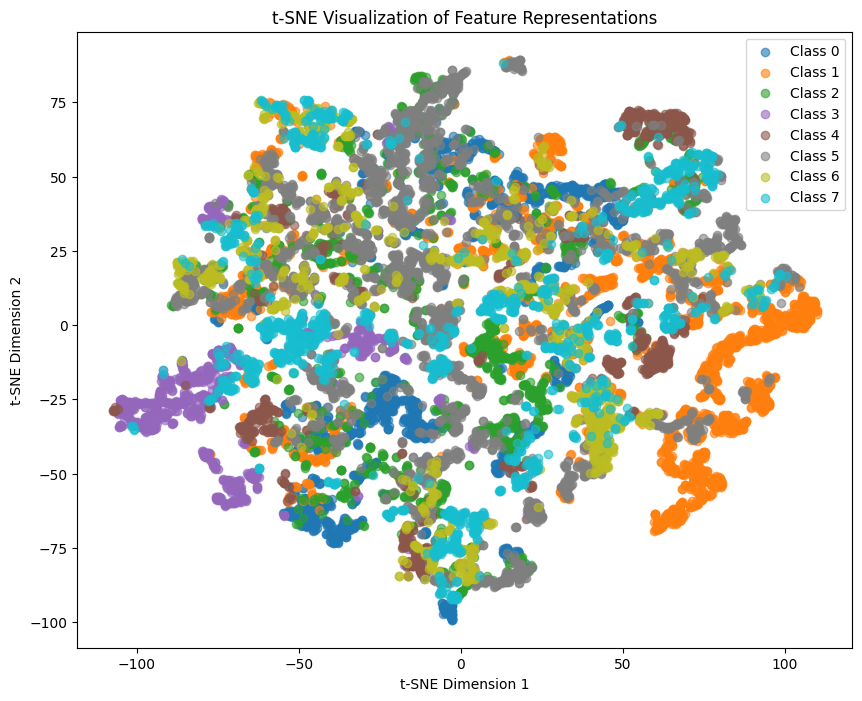

In [11]:
features, labels = inf.extract_features(model, data_loader_training)
from sklearn.manifold import TSNE
# Step 3: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Step 4: Plot the t-SNE result
def plot_tsne(features_2d, labels, num_classes=8):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap("tab10", num_classes)  # Colormap for different classes
    for class_id in range(num_classes):
        indices = labels == class_id
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f"Class {class_id}", 
                    color=colors(class_id), alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Feature Representations")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Visualize t-SNE plot
plot_tsne(features_2d, labels, num_classes=8)

Accuracy: 9.97%


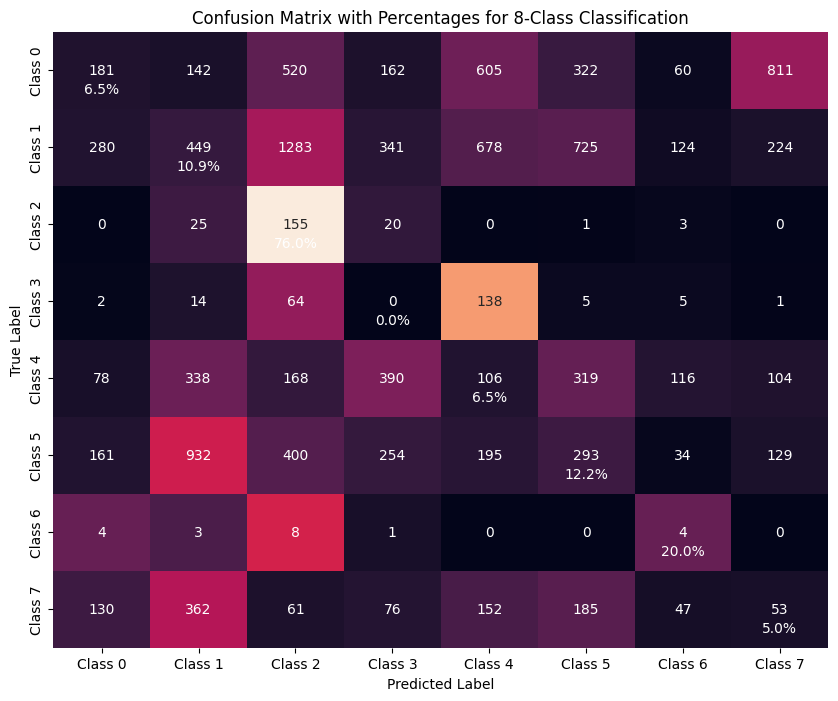

In [9]:
# Get predictions and true labels from the test dataloader
preds, labels = inf.get_predictions_and_labels(model, data_loader_test)

# Step 2: Compute Accuracy and Confusion Matrix
accuracy = accuracy_score(labels, preds)
conf_matrix = confusion_matrix(labels, preds)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 3: Normalize Confusion Matrix to Show Percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Step 4: Plot the Confusion Matrix with Percentages
def plot_confusion_matrix(conf_matrix, conf_matrix_percentage, num_classes=8):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix_percentage, annot=conf_matrix, fmt="d",  cbar=False,
                     xticklabels=[f"Class {i}" for i in range(num_classes)],
                     yticklabels=[f"Class {i}" for i in range(num_classes)]) #cmap="Blues",
    # Add percentage text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i == j:
                ax.text(j + 0.5, i + 0.75, f"{conf_matrix_percentage[i, j]:.1f}%", 
                        ha="center", va="center", color="white")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix with Percentages for 8-Class Classification")
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, conf_matrix_percentage, num_classes=8)

### Supervised ResNet

In [10]:
supervised_best_model_name = '/data2/hkaman/Projects/Foundational/EXPs/EXP_supervised_resnet/best_model.pth'

In [11]:
base_model = resnet_simclr.ResNetSimCLR(base_model='resnet50', out_dim = 128).to(device)
model = inf.FineTunedResNetSimCLR(base_model = base_model, num_classes=8).to(device)
model.to(device)
model.load_state_dict(torch.load(supervised_best_model_name))

<All keys matched successfully>

Accuracy: 18.07%


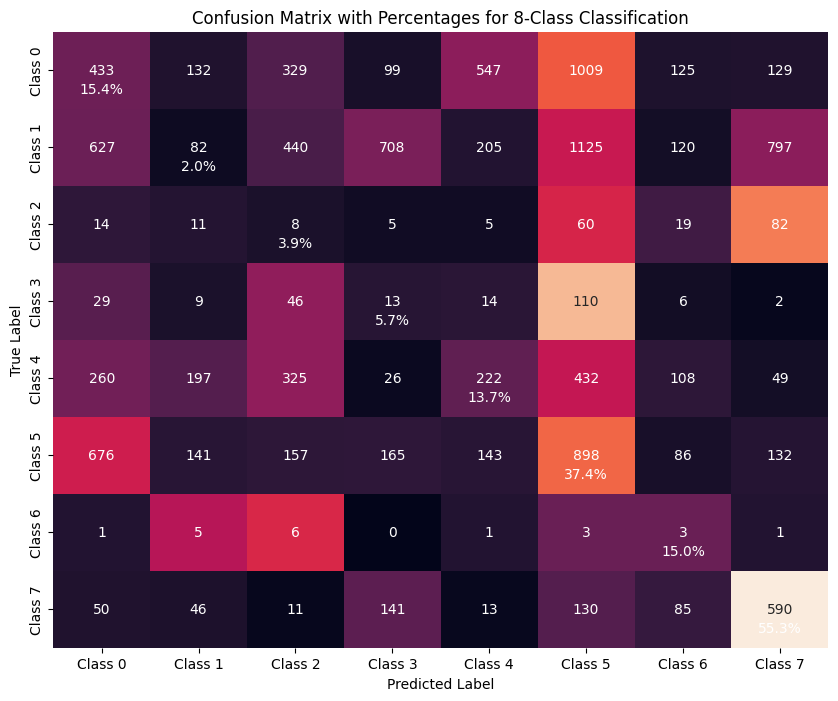

In [13]:
# Get predictions and true labels from the test dataloader
preds, labels = inf.get_predictions_and_labels(model, data_loader_test)

# Step 2: Compute Accuracy and Confusion Matrix
accuracy = accuracy_score(labels, preds)
conf_matrix = confusion_matrix(labels, preds)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 3: Normalize Confusion Matrix to Show Percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Step 4: Plot the Confusion Matrix with Percentages
def plot_confusion_matrix(conf_matrix, conf_matrix_percentage, num_classes=8):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix_percentage, annot=conf_matrix, fmt="d",  cbar=False,
                     xticklabels=[f"Class {i}" for i in range(num_classes)],
                     yticklabels=[f"Class {i}" for i in range(num_classes)]) #cmap="Blues",
    # Add percentage text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i == j:
                ax.text(j + 0.5, i + 0.75, f"{conf_matrix_percentage[i, j]:.1f}%", 
                        ha="center", va="center", color="white")
                
                
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix with Percentages for 8-Class Classification")
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, conf_matrix_percentage, num_classes=8)